<h1 style="text-align:center; font-family:Georgia; font-weight:bold; ">DistilRoBERTa</h1>

## Imports


In [1]:
from transformers import AutoTokenizer, AutoModel
model_name = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
import re
import nltk
import spacy
import torch
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AdamW


## Set up NLP Tools


In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Preprocessed Data


In [5]:
preprocessed_data = pd.read_csv('./Preprocessed Data/preprocessed_text.csv')
print(f"Loaded preprocessed data with shape: {preprocessed_data.shape}")
print(f"Columns: {preprocessed_data.columns.tolist()}")
preprocessed_data.head()

Loaded preprocessed data with shape: (695131, 7)
Columns: ['Text', 'Emotion', 'happinessScore', 'neutralScore', 'sadnessScore', 'angerScore', 'fearScore']


,Text,Emotion,happinessScore,neutralScore,sadnessScore,angerScore,fearScore
0,expect feel content,happiness,0.0,0.0,0.0,0.0,0.0
1,couldnt help feeling little bit bitter towards...,happiness,0.0,0.0,0.0,0.0,0.0
2,know feels completely happy real world taught ...,happiness,0.0,0.0,0.0,0.0,0.0
3,walk door house feel happy,happiness,0.0,0.0,0.0,0.0,0.0
4,feel satisfied happy choices today,happiness,0.0,0.0,0.0,0.0,0.0


## Define Constants and Encoder


In [6]:
EMOTIONS = ['happiness', 'neutral', 'sadness', 'anger', 'fear']
MAX_LENGTH = 128

encoder = LabelEncoder()
encoder.classes_ = np.array(EMOTIONS)

## Check Data Structure and Features



In [7]:
assert 'Text' in preprocessed_data.columns, "Text column not found in preprocessed data"
assert 'Emotion' in preprocessed_data.columns, "Emotion column not found in preprocessed data"

score_columns = [col for col in preprocessed_data.columns if col.endswith('Score')]
print(f"Found score columns: {score_columns}")

if len(score_columns) > 0:
    print("Using lexicon scores as additional features")

Found score columns: ['happinessScore', 'neutralScore', 'sadnessScore', 'angerScore', 'fearScore']
Using lexicon scores as additional features


## Encode Labels and Analyze Distribution



In [8]:
preprocessed_data['label'] = encoder.transform(preprocessed_data['Emotion'])

emotion_counts = preprocessed_data['Emotion'].value_counts()
print("Emotion distribution in dataset:")
print(emotion_counts)

Emotion distribution in dataset:
neutral      316935
happiness    146622
sadness      123541
anger         60369
fear          47664
Name: Emotion, dtype: int64


## Visualize Emotion Distribution


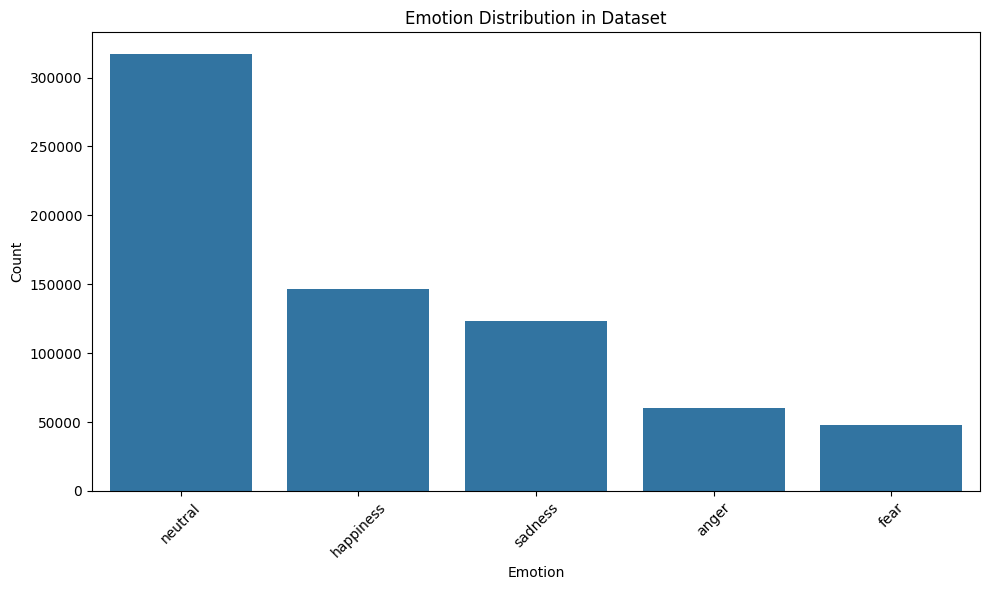

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Emotion Distribution in Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Split Data into Train, Validation, and Test Sets



In [10]:
train_data, temp_data = train_test_split(
    preprocessed_data, test_size=0.3, stratify=preprocessed_data['label'], random_state=42
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42
)

print(f"Train data: {train_data.shape[0]} samples")
print(f"Validation data: {val_data.shape[0]} samples")
print(f"Test data: {test_data.shape[0]} samples")

Train data: 486591 samples
Validation data: 104270 samples
Test data: 104270 samples


## Check Class Distribution in Splits


In [11]:
def show_class_distribution(data, title):
    class_counts = data['Emotion'].value_counts()
    print(f"\n{title} distribution:")
    print(class_counts)
    print(f"Total: {sum(class_counts)}")

show_class_distribution(train_data, "Train")
show_class_distribution(val_data, "Validation")
show_class_distribution(test_data, "Test")


Train distribution:
neutral      221854
happiness    102635
sadness       86479
anger         42258
fear          33365
Name: Emotion, dtype: int64
Total: 486591

Validation distribution:
neutral      47541
happiness    21993
sadness      18531
anger         9055
fear          7150
Name: Emotion, dtype: int64
Total: 104270

Test distribution:
neutral      47540
happiness    21994
sadness      18531
anger         9056
fear          7149
Name: Emotion, dtype: int64
Total: 104270


## Prepare Datasets for Hugging Face



In [18]:
def dataframe_to_dataset(df):
    df_copy = df.copy()
    df_copy['Text'] = df_copy['Text'].fillna('').astype(str)
    return Dataset.from_pandas(df_copy[['Text', 'label']])

train_dataset = dataframe_to_dataset(train_data)
val_dataset = dataframe_to_dataset(val_data)
test_dataset = dataframe_to_dataset(test_data)

train_dataset[:3]

{'Text': ['stop doubt leave feeling dissatisfied',
  'im feeling little bit greedy',
  'happy things moved part sort feels distressed purveyors may claim always'],
 'label': [1, 3, 4],
 '__index_level_0__': [151039, 612224, 675601]}

## Tokenize Text Data



In [19]:
model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    texts = [str(text) for text in examples["Text"]]
    return tokenizer(texts, padding="max_length", truncation=True, max_length=MAX_LENGTH)

try:
    print("Testing tokenization on a small sample...")
    small_sample = train_dataset.select(range(10))
    tokenized_sample = small_sample.map(tokenize_function, batched=True)
    print("Sample tokenization successful!")
    
    print("Tokenizing train dataset...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    print("Tokenizing validation dataset...")
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    print("Tokenizing test dataset...")
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
except Exception as e:
    print(f"Error during tokenization: {e}")
    print("\nInspecting text data quality...")
    
    print(f"NaN values in train_data['Text']: {train_data['Text'].isna().sum()}")
    print(f"NaN values in val_data['Text']: {val_data['Text'].isna().sum()}")
    print(f"NaN values in test_data['Text']: {test_data['Text'].isna().sum()}")
    
    print("\nSample of texts:")
    problematic = pd.concat([
        train_data[train_data['Text'].isna()].head(2),
        train_data[~train_data['Text'].astype(str).str.isalpha()].head(2)
    ])
    if len(problematic) > 0:
        print(problematic[['Text', 'Emotion']])
    
    def robust_tokenize_function(examples):
        # Clean texts: replace NaN with empty string and convert to string
        texts = [str(text) if pd.notna(text) else "" for text in examples["Text"]]
        return tokenizer(texts, padding="max_length", truncation=True, max_length=MAX_LENGTH)
    
    print("\nRetrying with robust tokenization function...")
    tokenized_train = train_dataset.map(robust_tokenize_function, batched=True)
    tokenized_val = val_dataset.map(robust_tokenize_function, batched=True)
    tokenized_test = test_dataset.map(robust_tokenize_function, batched=True)
    print("Tokenization completed successfully!")

Testing tokenization on a small sample...


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Sample tokenization successful!
Tokenizing train dataset...


Map:   0%|          | 0/486591 [00:00<?, ? examples/s]

Tokenizing validation dataset...


Map:   0%|          | 0/104270 [00:00<?, ? examples/s]

Tokenizing test dataset...


Map:   0%|          | 0/104270 [00:00<?, ? examples/s]

## Initialize Optimizer


In [38]:
optimizer = AdamW(model.parameters(), lr=2e-5)

C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Create Model and Training Loop



In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True)
val_loader = DataLoader(tokenized_val, batch_size=16)
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["label"])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Training loss: {total_loss:.4f}")

    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds += torch.argmax(logits, axis=-1).cpu().tolist()
            labels += batch["label"].cpu().tolist()

    acc = accuracy_score(labels, preds)
    print(f"Epoch {epoch+1} - Validation Accuracy: {acc:.4f}")


Epoch 1:   3%|▎         | 1028/30412 [1:39:18<47:18:27,  5.80s/it]



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dell\AppData\Local\Temp\ipykernel_17744\3534208781.py", line 18, in <module>
    outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["label"])
  File "C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py", line 1511, in _wrapped_call_impl
  File "C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py", line 1520, in _call_impl
  File "C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\transformers\models\roberta\modeling_roberta.py", line 1198, in forward
    outputs = self.roberta(
  File "C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\module.py", line 1511, in _wrapped_call_impl
  File "C:\Users\dell\A

## Create Confusion Matrix



In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Analyze Lexicon Score Impact


In [ ]:
score_columns = [col for col in preprocessed_data.columns if col.endswith('Score')]
if score_columns:
    test_scores = test_data[score_columns].values
    
    plt.figure(figsize=(12, 8))
    
    for i, emotion in enumerate(EMOTIONS):
        emotion_indices = np.where(true_labels == i)[0]
        
        avg_scores = np.mean(test_scores[emotion_indices], axis=0)
        
        plt.subplot(2, 3, i+1)
        plt.bar(range(len(score_columns)), avg_scores)
        plt.title(f'Avg Lexicon Scores for {emotion}')
        plt.xticks(range(len(score_columns)), [s.replace('Score', '') for s in score_columns], rotation=45)
    
    plt.tight_layout()
    plt.show()

## Save the Fine-Tuned Model


In [ ]:
model_save_path = "./distilroberta_emotion_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

## Create Prediction Function


In [21]:
def predict_emotion(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    
    emotion = EMOTIONS[predicted_class]
    return emotion

test_examples = [
    "I am so happy today, everything is wonderful!",
    "I feel so sad and depressed after what happened.",
    "I'm absolutely furious about the way they treated me.",
    "I'm really scared about what might happen next."
]

for text in test_examples:
    emotion = predict_emotion(text, tokenizer, model)
    print(f"Text: '{text}'\nPredicted emotion: {emotion}\n")

Text: 'I am so happy today, everything is wonderful!'
Predicted emotion: happiness

Text: 'I feel so sad and depressed after what happened.'
Predicted emotion: happiness

Text: 'I'm absolutely furious about the way they treated me.'
Predicted emotion: happiness

Text: 'I'm really scared about what might happen next.'
Predicted emotion: happiness



## Analyze Model Performance by Text Length


In [22]:
test_data['text_length'] = test_data['Text'].apply(len)
test_data['correct_prediction'] = pred_emotions == true_emotions

bins = [0, 50, 100, 150, 200, 300, 500, 1000, 10000]
test_data['length_bin'] = pd.cut(test_data['text_length'], bins=bins)
accuracy_by_length = test_data.groupby('length_bin')['correct_prediction'].mean()

plt.figure(figsize=(12, 6))
accuracy_by_length.plot(kind='bar')
plt.title('Model Accuracy by Text Length')
plt.xlabel('Text Length')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

samples_by_length = test_data.groupby('length_bin').size()
plt.figure(figsize=(12, 6))
samples_by_length.plot(kind='bar')
plt.title('Number of Samples by Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: object of type 'float' has no len()

## Visualize Attention Weights



In [ ]:
def visualize_attention(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    if attentions:
        last_layer_attention = attentions[-1][0].mean(dim=0).cpu().numpy()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(last_layer_attention, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
        plt.title(f"Attention Weights for: {text[:50]}...")
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not provide attention weights")

try:
    examples_for_attention = [
        "I am so happy today, everything is wonderful!",
        "I'm absolutely furious about the way they treated me."
    ]
    
    for example in examples_for_attention:
        visualize_attention(example, tokenizer, model)
except:
    print("This model architecture doesn't support attention visualization directly")